# Imports

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
import re
import warnings

from typing import Optional, List

from IPython.display import display

from tqdm import tqdm
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from controller import Controller
from nonparamtests import calculate_kruskal, calculate_ami

In [3]:
c = Controller('i01')

risk_mapping = {
    4: 'High risk',
    3: 'Moderately high risk',
    2: 'Medium risk',
    1: 'Moderately medium risk',
    0: 'Low risk',
}

# Load data

In [4]:
filepath = fr'{c.get_path_data_prepared()}/01_df_train_val_test.pkl'
df_train_val_test = pd.read_pickle(filepath)

df_train = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Train"')
print(f'{df_train.shape=}')
df_val = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Validation"')
print(f'{df_val.shape=}')
df_test = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Test"')
print(f'{df_test.shape=}')

df_train_val_test

df_train.shape=(38655, 113)
df_val.shape=(4295, 113)
df_test.shape=(4773, 113)


,ACN_NUM_ACN,TIME_DATE,TIME_1_LOCAL_TIME_OF_DAY,PLACE_LOCALE_REFERENCE,PLACE_1_STATE_REFERENCE,PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL,PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES,PLACE_4_ALTITUDE_AGL_SINGLE_VALUE,PLACE_5_ALTITUDE_MSL_SINGLE_VALUE,ENVIRONMENT_FLIGHT_CONDITIONS,...,EVENTS_5_RESULT,ASSESSMENTS_CONTRIBUTING_FACTORS_SITUATIONS,ASSESSMENTS_1_PRIMARY_PROBLEM,REPORT_1_NARRATIVE,REPORT_1_1_CALLBACK,REPORT_2_NARRATIVE,REPORT_2_1_CALLBACK,REPORT_1_2_SYNOPSIS,TRAIN_VAL_TEST_SPLIT,EVENT_RISK
0,1574675,201808,0601-1200,SNA.Airport,CA,NaN,NaN,NaN,5000.0,NaN,...,Air Traffic Control Issued New Clearance; Flig...,Human Factors,Human Factors,SNA RNP-Z to Runway 20R. The FMC was properly ...,NaN,We were cleared for the RNP RNAV Z 20R Approac...,NaN,B737-700 flight crew reported failing to make ...,Train,2
1,1224894,201412,0601-1200,MSY.Airport,LA,NaN,NaN,1000.0,NaN,VMC,...,General None Reported / Taken,Human Factors,Human Factors,On base to final turn to runway 1 in MSY at ap...,NaN,NaN,NaN,Captain reports sighting of a drone at 1;000 f...,Train,0
2,1134202,201312,1201-1800,ZZZ.ARTCC,US,NaN,NaN,NaN,2600.0,IMC,...,Air Traffic Control Provided Assistance; Air T...,Human Factors; Aircraft; Procedure; Weather,Aircraft,I climbed to my filed altitude of 5;000 FT; an...,NaN,NaN,NaN,SR22 pilot became disoriented on approach in I...,Train,3
3,1222074,201411,1201-1800,CWA.Airport,WI,NaN,20.0,NaN,4000.0,NaN,...,Flight Crew Became Reoriented; General Mainten...,Aircraft,Aircraft,I had my pitot heat checked prior to winter an...,NaN,NaN,NaN,BE58 pilot experiences pitot heat failure desc...,Train,2
4,1733019,202003,1801-2400,ZDV.ARTCC,CO,NaN,NaN,NaN,32000.0,NaN,...,Air Traffic Control Issued New Clearance; Flig...,Airspace Structure; Weather,Weather,At 32000 ft. just north of PUB the aircraft ex...,NaN,NaN,NaN,B737 First Officer reported unexpected moderat...,Train,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,1341108,201603,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,NaN,IMC,...,Air Traffic Control Provided Assistance; Fligh...,Company Policy; Human Factors,Human Factors,We did an originator out of ZZZ and had a main...,NaN,[Report narrative contained no additional info...,NaN,CRJ-900 flight crew reported being dispatched ...,Test,3
47719,1087474,201305,1201-1800,PHX.Airport,AZ,NaN,NaN,NaN,8000.0,VMC,...,Air Traffic Control Issued Advisory / Alert; F...,Aircraft; Human Factors; Procedure,Ambiguous,PHX takeoff Runway 25R flaps 5. CLEARANCE: MAX...,NaN,There was an Airbus that departed before us an...,NaN,CE750 flight crew departing PHX Runway 25R on ...,Test,3
47720,1756601,202008,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,General None Reported / Taken,Environment - Non Weather Related; Company Pol...,Company Policy,I was scheduled to complete the one day traini...,NaN,NaN,NaN,Air carrier First Officer reported that re-qua...,Test,0
47721,1102938,201307,0601-1200,MEM.Airport,TN,NaN,NaN,NaN,NaN,VMC,...,Air Traffic Control Issued New Clearance; Flig...,Airspace Structure; Chart Or Publication; Proc...,Human Factors,We departed Runway 36C in MEM via the GOETZ TW...,NaN,NaN,NaN,On initial climb out via the GOETZ RNAV SID fr...,Test,2


In [5]:
filepath = fr'{c.get_path_iteration()}/{c.iteration}_ss.pkl'
with open(filepath, 'rb') as f:
    selection_set = pickle.load(f)
len(selection_set)

110

# Population Flows

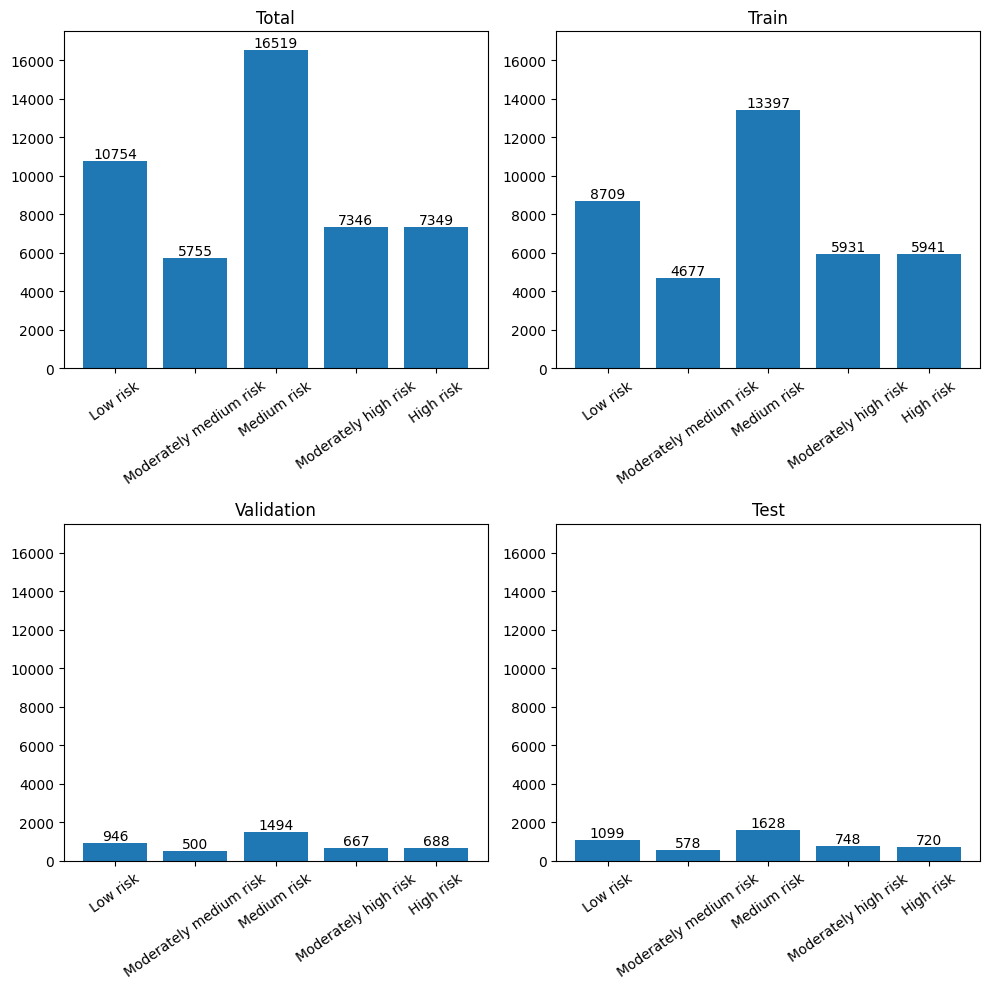

In [6]:
column = 'EVENT_RISK'
dfs = [
    ('Total', df_train_val_test, 0, 0),
    ('Train', df_train, 0, 1),
    ('Validation', df_val, 1, 0),
    ('Test', df_test, 1, 1),
]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for (dataset, df, i, j) in dfs:
    flag_frequencies = pd.concat([
        df[column].value_counts(dropna=False),
        df[column].value_counts(dropna=False, normalize=True),
    ], axis=1, keys=['# Total', '% Total']).sort_index()
    flag_frequencies.index = flag_frequencies.index.map(risk_mapping.get)
    
    index = flag_frequencies['# Total'].index
    values = [round(val, 2) for val in flag_frequencies['# Total'].values]

    bars = ax[i, j].bar(index, values)
    ax[i, j].tick_params(axis='x', labelrotation=35)
    ax[i, j].bar_label(bars)
    ax[i, j].set_ylim([0, 17_500])
    ax[i, j].set_title(dataset)

plt.tight_layout()

# Data audit

For each column in the dataframe, perform univariate analysis.

In [7]:
class DataAudit:
    def __init__(self):
        self.summary_sheet_name = 'Summary'
        self._feature_name_limit = 31
        self.df: pd.DataFrame = None
        self.data_audit_summary: pd.DataFrame = None
        self.feature_dfs: dict(str, pd.DataFrame) = {}
        self.columns = ['Variable', 'Label', 'Type', '% Unique', '% Missing', 'mean', 'std', 'min', '50%', 'max', 'Comment']
  
  
    def fit(self, df: pd.DataFrame, target_feature:pd.Series, selection_set: list[str]=None) -> None:
        df = df.copy()
    
        self.df = df if selection_set is None else df[selection_set]
    
        # Construct skeleton of data audit dataframe
        self.data_audit_summary = self.df \
            .describe(include='all', percentiles=[0.5]) \
            .T \
            .convert_dtypes() \
            .reset_index(drop=False, names='Variable') \
            .drop(['top', 'freq'], axis=1)
            
        # Add label for each column
        self.data_audit_summary['Label'] = '.'
        self.data_audit_summary['Comment'] = '.'
        
        # Add the types of each column
        self.data_audit_summary['Type'] = self.df[self.data_audit_summary['Variable']].dtypes.values
        
        # Calculate the number of entries for all columns
        self.data_audit_summary['count'] = self.df[self.data_audit_summary['Variable']].count().values
        
        # Calculate the number of unique entries for all columns
        self.data_audit_summary['unique'] = self.df[self.data_audit_summary['Variable']].nunique().values
        
        # Calculate percentage of unique values
        self.data_audit_summary['% Unique'] = (self.data_audit_summary['unique'] / self.data_audit_summary['count']).map(lambda value: round(value, 4))
        
        # Calculate percentage of missing values
        self.data_audit_summary['% Missing'] = self.df[self.data_audit_summary['Variable']].isna().mean().values
        self.data_audit_summary['% Missing'] = self.data_audit_summary['% Missing'].map(lambda value: round(value, 4))

        # Univariate analysis for all features
        pbar = tqdm(self.df.columns)
        for feature in pbar:
            pbar.set_postfix_str(f'Processing {feature}')
            
            flag_frequencies = pd.concat([
                self.df[feature].value_counts(dropna=False),
                self.df[feature].value_counts(dropna=False, normalize=True),
            ], axis=1, keys=['# Total', '% Total']).sort_index()
            flag_frequencies = flag_frequencies.reset_index(drop=False, names='Value')
            flag_frequencies['% Total'] = flag_frequencies['% Total'].map(lambda value: round(value, 4))
            flag_frequencies = flag_frequencies.fillna('NA')
            self.feature_dfs[feature[:self._feature_name_limit]] = flag_frequencies
        
        # Reorder the columns
        self.data_audit_summary = self.data_audit_summary[self.columns]
        self.data_audit_summary.columns = self.data_audit_summary.columns.map(str.upper)
        
        
    def export(self, filepath: str) -> None:
        with pd.ExcelWriter(filepath) as writer:
            self.data_audit_summary.to_excel(excel_writer=writer, sheet_name=self.summary_sheet_name)
            
            # Get the openpyxl workbook and worksheet objects
            wb = writer.book
            ws_summary = wb[self.summary_sheet_name]
            
            # Add hyperlinks to the summary sheet for each feature
            pbar = tqdm(enumerate(self.feature_dfs))
            for i, feature in pbar:
                pbar.set_postfix_str(f'Exporting {feature}')
                
                cell = ws_summary.cell(row=i+2, column=2)
                cell.value = feature
                cell.hyperlink = f"#{feature}!A1"

                # Write the feature data to a new sheet in the output file
                self.feature_dfs[feature].to_excel(writer, sheet_name=feature)

                # Add a hyperlink to the summary sheet from the feature sheet
                ws_feature = wb[feature]
                cell = ws_feature.cell(row=1, column=1)
                cell.value = self.summary_sheet_name
                cell.hyperlink = f"#{self.summary_sheet_name}!A1"
                
    
    def extend_summary(self, columns: List[pd.Series]) -> None:
        for col in columns:
            self.data_audit_summary = pd.merge(
                self.data_audit_summary,
                col,
                how='left',
                left_on='VARIABLE',
                right_index=True
            )
                
                
    def view_summary(self, display_only=True) -> Optional[pd.DataFrame]:
        if not display_only:
            return self.data_audit_summary.copy()   
        
        display(self.data_audit_summary)
    
    
    def view(self, feature, display_only=True) -> Optional[pd.DataFrame]:
        df_result = self.feature_dfs.get(feature, None)

        if df_result is None:
            warnings.warn(f'Feature {feature} not present')
            return

        if not display_only:
            return df_result.copy()

        display(df_result)

In [8]:
data_audit_full = DataAudit()
data_audit_full.fit(df_train_val_test, df_train_val_test['EVENT_RISK'], selection_set=selection_set)
data_audit_full.view_summary()

100%|██████████| 110/110 [00:01<00:00, 80.68it/s, Processing REPORT_1_2_SYNOPSIS]                                                 


,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT
0,ACN_NUM_ACN,.,int64,1.0000,0.0000,1429583.833812,273143.371337,986560,1429176,1881918,.
1,TIME_DATE,.,int64,0.0023,0.0000,201665.241854,296.40195,201201,201703,202203,.
2,TIME_1_LOCAL_TIME_OF_DAY,.,object,0.0001,0.1035,<NA>,<NA>,<NA>,<NA>,<NA>,.
3,PLACE_LOCALE_REFERENCE,.,object,0.0492,0.0603,<NA>,<NA>,<NA>,<NA>,<NA>,.
4,PLACE_1_STATE_REFERENCE,.,object,0.0015,0.0603,<NA>,<NA>,<NA>,<NA>,<NA>,.
...,...,...,...,...,...,...,...,...,...,...,...
105,REPORT_1_NARRATIVE,.,object,0.9998,0.0000,<NA>,<NA>,<NA>,<NA>,<NA>,.
106,REPORT_1_1_CALLBACK,.,object,0.9930,0.9699,<NA>,<NA>,<NA>,<NA>,<NA>,.
107,REPORT_2_NARRATIVE,.,object,0.7561,0.7647,<NA>,<NA>,<NA>,<NA>,<NA>,.
108,REPORT_2_1_CALLBACK,.,object,1.0000,0.9982,<NA>,<NA>,<NA>,<NA>,<NA>,.


In [9]:
data_audit_train = DataAudit()
data_audit_train.fit(df_train, df_train['EVENT_RISK'], selection_set=selection_set)
data_audit_train.view_summary()

100%|██████████| 110/110 [00:01<00:00, 86.72it/s, Processing REPORT_1_2_SYNOPSIS]                                                 


,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT
0,ACN_NUM_ACN,.,int64,1.0000,0.0000,1428314.543423,273213.873552,986560,1428078,1881918,.
1,TIME_DATE,.,int64,0.0029,0.0000,201663.858026,296.471514,201201,201702,202203,.
2,TIME_1_LOCAL_TIME_OF_DAY,.,object,0.0001,0.1035,<NA>,<NA>,<NA>,<NA>,<NA>,.
3,PLACE_LOCALE_REFERENCE,.,object,0.0555,0.0587,<NA>,<NA>,<NA>,<NA>,<NA>,.
4,PLACE_1_STATE_REFERENCE,.,object,0.0019,0.0586,<NA>,<NA>,<NA>,<NA>,<NA>,.
...,...,...,...,...,...,...,...,...,...,...,...
105,REPORT_1_NARRATIVE,.,object,0.9999,0.0000,<NA>,<NA>,<NA>,<NA>,<NA>,.
106,REPORT_1_1_CALLBACK,.,object,0.9941,0.9694,<NA>,<NA>,<NA>,<NA>,<NA>,.
107,REPORT_2_NARRATIVE,.,object,0.7599,0.7643,<NA>,<NA>,<NA>,<NA>,<NA>,.
108,REPORT_2_1_CALLBACK,.,object,1.0000,0.9984,<NA>,<NA>,<NA>,<NA>,<NA>,.


In [10]:
numeric_features = df_train[selection_set].select_dtypes('object').columns
amis = calculate_ami(df_train, numeric_features, df_train['EVENT_RISK'])
amis

TIME_1_LOCAL_TIME_OF_DAY                             0.011183
PLACE_LOCALE_REFERENCE                               0.020424
PLACE_1_STATE_REFERENCE                              0.022188
PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL               0.002902
PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES    0.004907
                                                       ...   
REPORT_1_NARRATIVE                                   0.000030
REPORT_1_1_CALLBACK                                  0.005068
REPORT_2_NARRATIVE                                   0.005447
REPORT_2_1_CALLBACK                                  0.000334
REPORT_1_2_SYNOPSIS                                  0.000126
Name: AMI, Length: 107, dtype: float64

In [11]:
numeric_features = df_train[selection_set].select_dtypes('number').columns
kruskal_pvalues = calculate_kruskal(df_train, numeric_features, df_train['EVENT_RISK'])
kruskal_pvalues

ACN_NUM_ACN                                        1.000000
TIME_DATE                                          0.136451
PERSON_1_10_ASRS_REPORT_NUMBER_ACCESSION_NUMBER    1.000000
Name: KRUSKAL, dtype: float64

In [12]:
data_audit_train.extend_summary([amis, kruskal_pvalues])
data_audit_train.view_summary()

,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT,AMI,KRUSKAL
0,ACN_NUM_ACN,.,int64,1.0000,0.0000,1428314.543423,273213.873552,986560,1428078,1881918,.,NaN,1.000000
1,TIME_DATE,.,int64,0.0029,0.0000,201663.858026,296.471514,201201,201702,202203,.,NaN,0.136451
2,TIME_1_LOCAL_TIME_OF_DAY,.,object,0.0001,0.1035,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.011183,NaN
3,PLACE_LOCALE_REFERENCE,.,object,0.0555,0.0587,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.020424,NaN
4,PLACE_1_STATE_REFERENCE,.,object,0.0019,0.0586,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.022188,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,REPORT_1_NARRATIVE,.,object,0.9999,0.0000,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.000030,NaN
106,REPORT_1_1_CALLBACK,.,object,0.9941,0.9694,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.005068,NaN
107,REPORT_2_NARRATIVE,.,object,0.7599,0.7643,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.005447,NaN
108,REPORT_2_1_CALLBACK,.,object,1.0000,0.9984,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.000334,NaN


# Saving to files

In [13]:
filepath = f'{c.get_path_iteration()}/data_audit_full.xlsx'
data_audit_full.export(filepath)

filepath = f'{c.get_path_iteration()}/data_audit_train.xlsx'
data_audit_train.export(filepath)

110it [00:55,  1.97it/s, Exporting REPORT_1_2_SYNOPSIS]            
110it [00:38,  2.83it/s, Exporting REPORT_1_2_SYNOPSIS]            
